# Synthetic Diffusion for Generating Realistic Synthetic Images

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Synthetic Data Augumentation
import torch
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
# Standard Imports
from src.data.file_utils import GetTV

# Synthetic Image Generation
from src.external.cam_geo import fake_camera_raw_lite as cg
from src.visualization import visualize as vis

## Synthetic Image Generation

### Raw Synthetic

In [1]:
file_idx = 10
idx = 110

tv = GetTV('../data/raw/tv_images')
files = tv.list_files()
inverted = tv.load(files[file_idx], 'inverted')[idx]
frame = tv.load(files[file_idx], 'frames')[idx]
vid = tv.load(files[file_idx], 'vid')[int(frame)]
r_arr = tv.load(files[file_idx], 'radii')[0]
z_arr = tv.load(files[file_idx], 'elevation')[0]

NameError: name 'GetTV' is not defined

In [59]:
threshold = 0.2

r_coords, z_coords = np.where(inverted > threshold)
r_loc = r_arr[r_coords]
z_loc = z_arr[z_coords]
intensity = inverted[r_coords, z_coords]
test_arr = np.zeros_like(inverted)
test_intensity = np.zeros_like(inverted)
test_intensity[r_coords, z_coords] = intensity

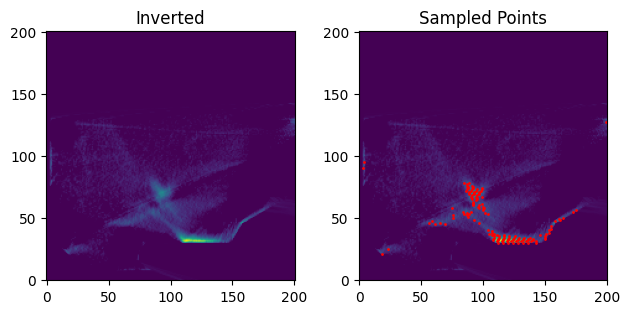

In [70]:
mode = 'L-mode'
skipnum = 4
choose_idx = 20

fig, ax = plt.subplots(1, 2)

r_2 = [r_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
z_2 = [z_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]

# Plot on the first subplot
ax[0].imshow(inverted, origin='lower')
ax[0].set_title('Inverted')

# Plot on the second subplot
ax[1].imshow(inverted, origin='lower')
ax[1].scatter(z_2,r_2, s = 1, c = 'red')
ax[1].set_title('Sampled Points')

plt.tight_layout()
plt.show()


In [92]:
def make_samples(skipnum, inv_dat):
    r_coords, z_coords = np.where(inv_dat['inverted'] > .1)
    if skipnum == 0:
        r_2 = [r_coords[i] for i in range(len(r_coords))]
        z_2 = [z_coords[i] for i in range(len(r_coords))]
    elif skipnum > 0:
        r_2 = [r_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
        z_2 = [z_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
    else:
        assert('skipnum must be a positive integer')
        
    r_loc = inv_dat['r_arr'][r_2]
    z_loc = inv_dat['z_arr'][z_2]
    intensity = inv_dat['inverted'][r_coords, z_coords]
    
    R0s = np.array([r_loc])
    Z0s = np.array([z_loc])
    
    nsample = Z0s.shape[0]
    
    A0s = np.array([intensity])
    M0s = np.ones((nsample,len(intensity))) * 0.001
    
    return R0s, Z0s, A0s, M0s, nsample

def make_setup(skip_num = 0, inv_dat = None):

    save_name= 'synthetic_outers.h5'
    chunk_size = 200
    
    Rinfo = {}
    Rinfo['outfile'], Rinfo['chunk_size'] = save_name, chunk_size
    Rinfo['R0s'], Rinfo['Z0s'], Rinfo['A0s'], Rinfo['M0s'], Rinfo['nsample'] = make_samples(skip_num, inv_dat)

    if Rinfo['nsample'] < Rinfo['chunk_size']:
        Rinfo['chunk_size'] = Rinfo['nsample']
    
    return Rinfo

def make_synthetic(camgeo, inv_dat):
    Rinfo  = make_setup(inv_dat)
    image = cg._integrate_image(Rinfo, 0, camgeo=camgeo)
    image = cv2.convertScaleAbs(np.flip(image * 255, 0), alpha= 1.5, beta = 2)

In [93]:
# Main runs
camgeo = cg._load_camera(camera_save='../data/external/cam_geo/Camera_geo.pl',
                        filename1='../data/external/cam_geo/geom_240perp_unwarp_2022fwd.sav',
                        filename2='../data/external/cam_geo/cam240perp_geometry_2022.sav')

>>> Synthetic Camera dim. (240, 720)
>>> Inverted  Camera dim. (201, 201)


In [94]:
image = make_synthetic(camgeo,
                   inv_dat = {'r_arr': r_arr, 'z_arr': z_arr,
                               'r_coords': r_coords, 'z_coords': z_coords,
                               'inverted': inverted,
                               })

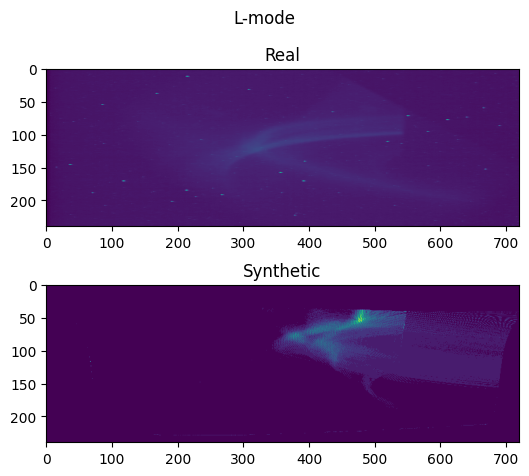

In [85]:
fig, ax = plt.subplots(2,1)
plt.suptitle(mode)
ax[0].imshow(vid)
ax[0].set_title('Real')
ax[1].imshow(image)
ax[1].set_title('Synthetic')
plt.tight_layout()
plt.show()

### Augumented Synthetic

#### Add Noise to Raw Synthetic

In [90]:
def add_noise(image, noise_level = 0.5):
    noise = np.random.normal(0, noise_level, image.shape)
    noisy = image + noise
    return noisy

def add_noise_2(image, noise_factor=0.1):
    image_array = np.array(image) / 255.0
    noise = np.random.normal(loc=0, scale=1, size=image_array.shape)
    noisy_image = image_array + noise_factor * noise
    noisy_image = np.clip(noisy_image, 0, 1)
    return Image.fromarray((noisy_image * 255).astype(np.uint8), mode="L")

def adaptive_noise(image, base_factor=0.1, edge_factor=0.05):
    image_array = np.array(image) / 255.0
    edges = cv2.Canny(image_array, 100, 200)
    noise = np.random.normal(loc=0, scale=1, size=image_array.shape)
    adaptive_factor = np.where(edges > 0, edge_factor, base_factor)
    noisy_image = image_array + adaptive_factor * noise
    return Image.fromarray((np.clip(noisy_image, 0, 1) * 255).astype(np.uint8), mode="L")

In [ ]:
def enhance_contrast(image):
    image_array = np.array(image)
    equalized = cv2.equalizeHist(image_array)
    return Image.fromarray(equalized)

In [ ]:
def multi_scale_refine(image, model, scales=[0.5, 1.0, 1.5]):
    results = []
    for scale in scales:
        scaled_image = image.resize((int(image.width * scale), int(image.height * scale)))
        refined = refine_image(scaled_image, model)
        results.append(refined.resize(image.size))
    return Image.blend(results[0], Image.blend(results[1], results[2], 0.5), 0.5)

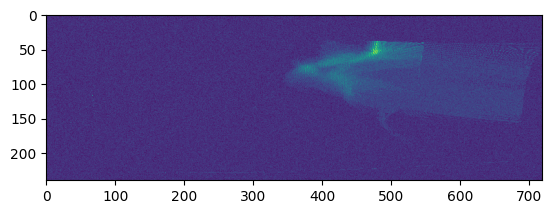

In [91]:
noisy_image = add_noise(image, 0.5)
plt.imshow(noisy_image)

#### Train Diffusion Model on Real Images

#### Augument Synthetic with Diffusion

In [ ]:
class MonochromeStableDiffusion(StableDiffusionImg2ImgPipeline):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Modify the first layer to accept single-channel input
        self.unet.conv_in = torch.nn.Conv2d(1, self.unet.conv_in.out_channels, kernel_size=3, padding=1)

In [ ]:
class GrayscalePerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg[x])
        
    def forward(self, input, target):
        input_gray = 0.299 * input[:, 0] + 0.587 * input[:, 1] + 0.114 * input[:, 2]
        target_gray = 0.299 * target[:, 0] + 0.587 * target[:, 1] + 0.114 * target[:, 2]
        h_x = self.slice1(input_gray.unsqueeze(1).repeat(1, 3, 1, 1))
        h_y = self.slice1(target_gray.unsqueeze(1).repeat(1, 3, 1, 1))
        return torch.mean((h_x - h_y) ** 2)

In [ ]:
grayscale_augmentations = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
])

In [ ]:
def prepare_grayscale_dataset(image_folder):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    return datasets.ImageFolder(image_folder, transform=transform)

# Use this dataset for fine-tuning your model

In [ ]:
def gradient_loss(pred, target):
    pred_grad_x = pred[:, :, 1:] - pred[:, :, :-1]
    pred_grad_y = pred[:, 1:, :] - pred[:, :-1, :]
    target_grad_x = target[:, :, 1:] - target[:, :, :-1]
    target_grad_y = target[:, 1:, :] - target[:, :-1, :]
    return F.l1_loss(pred_grad_x, target_grad_x) + F.l1_loss(pred_grad_y, target_grad_y)

In [ ]:
# Main pipeline
def image_refinement_pipeline(input_image_path, model_path, output_image_path):
    # Load the synthetic image
    synthetic_image = load_image(input_image_path)
    
    # Add noise to the synthetic image
    noisy_image = add_noise(synthetic_image, noise_factor=0.1)
    
    # Load the fine-tuned diffusion model
    model = StableDiffusionImg2ImgPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
    
    # Refine the noisy image
    refined_image = refine_image(noisy_image, model)
    
    # Save the result
    refined_image.save(output_image_path)

# Example usage
input_image_path = "path/to/synthetic_image.png"
model_path = "path/to/fine_tuned_diffusion_model"
output_image_path = "path/to/refined_image.png"

image_refinement_pipeline(input_image_path, model_path, output_image_path)

### Save Synthetic Datasets

### Train Real

### Train Synthetic

## Testing

### Visual Benchmark

### Accuracy Scores